# Essential gene classifier

Using experimentally determined gene essentiality data for prokaryotes from the [Online Gene Essentiality (OGEE) database](https://v3.ogee.info/#/home). Nucleotide and amino acid sequences are featurised to train logistic regression, Random Forest and XGBoost models as well as a feed-forward neural network. 

In [1]:
import os
import warnings
import math
import itertools
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
from Bio.SeqUtils.CodonUsage import CodonAdaptationIndex
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
warnings.filterwarnings("ignore")

/home/carolin/miniconda3/envs/tf/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Import Data

In [6]:
df = pd.read_csv('df_ortholog.csv') 

# filter out gene sequences whose lengths aren't multiples of 3
df = df[df['gene_sequence'].map(len)%3==0]

# filter out gene sequences that contain non ATGC letters
nonATGC = [any(letter not in ['A','T','G','C'] for letter in seq) for seq in df["gene_sequence"]]
datafilter = [not elem for elem in nonATGC]
data = df[datafilter]

# binarize strand
lb = sklearn.preprocessing.LabelBinarizer()
lb.fit([0, 1])
data["strand"] = lb.transform(data[["strand"]])

# create dummy variables for operon position
data = pd.get_dummies(data, columns=['operon_pos'], drop_first=True)

# recode essentiality as 0 (non-essential) and 1 (essential)
data['essentiality'] = data['essentiality'].astype('category')
data['essentiality'].replace({'E': 1,'NE': 0}, inplace=True)

data = data.iloc[:,2:].reset_index()
data = data[['geneID', 'SpeciesName', 'locus', 'gene', 'Gram','Taxonomy', 'taxaID', 'gene_sequence',
              'protein_sequence','strand','orthogroup','operon_pos_1','operon_pos_2','essentiality',]]


In [7]:
data.head()

,geneID,SpeciesName,locus,gene,Gram,Taxonomy,taxaID,gene_sequence,protein_sequence,strand,orthogroup,operon_pos_1,operon_pos_2,essentiality
0,Bacteroides fragilis 638R_BF638R_0014,Bacteroides fragilis 638R,BF638R_0014,NaN,GN,Bacteroidetes,862962,ATGACTATTATTTTTCCTTCTCCTATATTCGGACCGGTTCATTCAC...,MTIIFPSPIFGPVHSRRLGVSLGINLLPSDGKVCSFDCIYCECGYN...,1,OG0003967,0,1,1
1,Bacteroides fragilis 638R_BF638R_0030,Bacteroides fragilis 638R,BF638R_0030,NaN,GN,Bacteroidetes,862962,ATGTTACTTCTTTATATGGCATCATTATCTGAGTCCATATACCCGG...,MLLLYMASLSESIYPGSSARIPGLMGLCTRDDGHRYAGRDKEKTIF...,0,NaN,0,0,1
2,Bacteroides fragilis 638R_BF638R_0032,Bacteroides fragilis 638R,BF638R_0032,NaN,GN,Bacteroidetes,862962,ATGACAAAAGGATCTTTATTACGAAAAAGATATACATCGCAATTCT...,MTKGSLLRKRYTSQFCTKYYPFLLKDYTQSGCSKNHILAATTIVKI...,0,NaN,0,1,1
3,Bacteroides fragilis 638R_BF638R_0042,Bacteroides fragilis 638R,BF638R_0042,NaN,GN,Bacteroidetes,862962,ATGAGTAAAAAGATTTTTGCGGCCCTGATAGTCGCTGTAGTCGCAA...,MSKKIFAALIVAVVATFAGYNIYQSQRVESIMSDLTMANVEALAGS...,1,OG0006518,0,0,1
4,Bacteroides fragilis 638R_BF638R_0051,Bacteroides fragilis 638R,BF638R_0051,NaN,GN,Bacteroidetes,862962,ATGAATAAACTCACTATAAATGCCTGTCCGCTATGTGGGGGCGCAC...,MNKLTINACPLCGGAHLKRAMTCTDFYASGEQFDLYTCEDCGFTFT...,1,OG0000156,0,1,1


In [8]:
data.shape

(92624, 14)

In [9]:
# look at class distribution
data.essentiality.value_counts()

0    70349
1    22275
Name: essentiality, dtype: int64

# Featurization

### GC Content

In [10]:
def getGCcontent(sequence):
    '''
    Calculates the GC content of a nucleotide sequence
    
    Args:
        sequence(str): a nucleotide sequence
    Returns:
        gc(float): GC content of the sequence
    '''
    
    gc = (sequence.count('G') + sequence.count('C'))/len(sequence)
    return gc

### Codon Frequency

In [11]:
# codon dictionary
CodonDict = {
    'TTT': 0, 'TTC': 0, 'TTA': 0, 'TTG': 0, 'CTT': 0,
    'CTC': 0, 'CTA': 0, 'CTG': 0, 'ATT': 0, 'ATC': 0,
    'ATA': 0, 'ATG': 0, 'GTT': 0, 'GTC': 0, 'GTA': 0,
    'GTG': 0, 'TAT': 0, 'TAC': 0, 'TAA': 0, 'TAG': 0,
    'CAT': 0, 'CAC': 0, 'CAA': 0, 'CAG': 0, 'AAT': 0,
    'AAC': 0, 'AAA': 0, 'AAG': 0, 'GAT': 0, 'GAC': 0,
    'GAA': 0, 'GAG': 0, 'TCT': 0, 'TCC': 0, 'TCA': 0,
    'TCG': 0, 'CCT': 0, 'CCC': 0, 'CCA': 0, 'CCG': 0,
    'ACT': 0, 'ACC': 0, 'ACA': 0, 'ACG': 0, 'GCT': 0,
    'GCC': 0, 'GCA': 0, 'GCG': 0, 'TGT': 0, 'TGC': 0,
    'TGA': 0, 'TGG': 0, 'CGT': 0, 'CGC': 0, 'CGA': 0,
    'CGG': 0, 'AGT': 0, 'AGC': 0, 'AGA': 0, 'AGG': 0,
    'GGT': 0, 'GGC': 0, 'GGA': 0, 'GGG': 0}
    
def getCodonFreq(sequence):
    '''
    Calculate frequency of all codons in a nucleotide sequence
    
    Args:
        sequence(str): an amino acid sequence
    Returns:
        FreqList(list): list of frequencies for all codons in the sequence (64 elements)
    '''
    
    tmp_dict = CodonDict.copy()

    num_codons = len(sequence)/3
    for j in range(0, len(sequence)-2, 3):
        codon = sequence[j:j+3]
        if codon in CodonDict.keys():
            tmp_dict[codon] += 1

    tmp_dict.update((x, y/num_codons) for x, y in tmp_dict.items())
    FreqList = [tmp_dict[codon] for codon in tmp_dict.keys()]

    return FreqList

### Codon Adaptation Index

In [12]:
def getCAI(sequence):
    '''
    Calculate codon adaptation index of a nucleotide sequence
    
    Args:
        sequence(str): a nucleotide sequence
    Returns:
        score(float): codon adaptation index for the nucleotide sequence
    '''
    cai = CodonAdaptationIndex()
    score = cai.cai_for_gene(sequence)
    return score

### Protein Sequence AA Frequency

In [13]:
# amino acids dictionary
AminoAcidDict = {
    'A': 0, 'R': 0, 'N': 0, 'D': 0,
    'C': 0, 'Q': 0, 'E': 0, 'G': 0,
    'H': 0, 'I': 0, 'L': 0, 'K': 0,
    'M': 0, 'F': 0, 'P': 0, 'S': 0,
    'T': 0, 'W': 0, 'Y': 0, 'V': 0
}

# returns protein sequence amino acid count / protein length (20 value vector)
def getAAFreq(protein_sequence):
    '''
    Calculate frequency of amino acids in an amino acid frequency
    
    Args:
        protein_sequence(str): an amino acid sequence
    Returns:
        FreqList(list): list of frequencies for all 20 amino acids in the amino acid sequence
    '''
    
    AminoAcids = AminoAcidDict.copy()

    for i in range(0, len(protein_sequence)):
        if protein_sequence[i] in AminoAcids:
            AminoAcids[protein_sequence[i]] += 1           

    FreqList = [AminoAcids[key]/len(protein_sequence) for key in AminoAcids]
 
    return FreqList

In [14]:
def featurize(sequence, protein_sequence):
    '''
    Get nucleotide and amino acid sequence-based features
    
    Args: 
        sequence(str): gene sequence
        protein_sequence(str): amino acid sequence  
    Returns: 
        X(list): 87 element array including GC content, gene length,
        codon frequency, CAI, amino acid frequency
    '''
    
    GC = getGCcontent( sequence )
    geneLength = float(len( sequence ))
    codonFreq = getCodonFreq( sequence )
    CAI = getCAI( sequence )
    proteinFeat = getAAFreq(protein_sequence)

    X = [geneLength] + [GC] + codonFreq + [CAI] + proteinFeat
    
    return X

Features:

*   Gene length (numeric)
*   GC Content (numeric)
*   Codon frequency (64-unit vector)
*   Codon Adaptation Index CAI (numeric)
*   Protein amino acid frequency (19-unit vector)
*   Strand (numeric)
*   Operon position (numeric)

In [15]:
def getXy(df):
    
    '''
    Create inputs for training ML models
    
    Args:
        df(dataframe): dataframe containing gene identifiers, nucleotide sequences,
                            amino acid sequences, strand and operon position
    Returns:
        X(array): array with input features for each gene
        y(array): array with labels (0/1) for each gene
    '''
    
    X = []
    for i in range(df.shape[0]):
        gene_seq = df["gene_sequence"][i]
        protein_seq = df["protein_sequence"][i]
        feature_vec = featurize(gene_seq, protein_seq) + [df["strand"][i]] +\
            [df["operon_pos_1"][i]] + [df["operon_pos_2"][i]]
        X.append(np.array(feature_vec))

    X = np.array(X)
    y = np.array(df["essentiality"])
    return X, y

# Train/Val/Test Split

Train/Val/Test split based on groups of orthologous genes; this is done to prevent data leakage between the different data sets.

In [16]:
# genes in orthogroups
data_orthogroup = data.loc[data.orthogroup.notna()]
data_orthogroup.index = range(data_orthogroup.shape[0])
print(data_orthogroup.shape[0])

# genes without orthogroups
data_no_orthogroup = data.loc[data.orthogroup.isna()]
data_no_orthogroup.index = range(data_no_orthogroup.shape[0])
print(data_no_orthogroup.shape[0])

82706
9918


In [17]:
# split genes with orthogroups into train/val/test such that an orthogroup only appears in train or test, not both
# 70/10/20 train/val/test
gss1 = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=20)
train_val_idx, test_idx = next(gss1.split(data_orthogroup, groups= data_orthogroup["orthogroup"]))
orthogroup_train_val = data_orthogroup.iloc[train_val_idx,:]
orthogroup_test = data_orthogroup.iloc[test_idx,:]   

orthogroup_train_val = orthogroup_train_val.reset_index(drop=True)

gss2 = GroupShuffleSplit(n_splits=1, test_size=0.125, random_state=20)
train_idx, val_idx = next(gss2.split(orthogroup_train_val, groups=orthogroup_train_val["orthogroup"]))
orthogroup_train = orthogroup_train_val.iloc[train_idx,:]
orthogroup_val = orthogroup_train_val.iloc[val_idx,:]

orthogroup_train.shape[0], orthogroup_val.shape[0], orthogroup_test.shape[0]

(58222, 7529, 16955)

In [18]:
# split genes without orthogroups using train_test_split
no_orthogroup_train_val, no_orthogroup_test = train_test_split(data_no_orthogroup, test_size=0.2, random_state=20)
no_orthogroup_train, no_orthogroup_val = train_test_split(no_orthogroup_train_val, test_size=0.125, random_state=20)

In [19]:
# combine orthogroups and no orthogroup data
data_train = pd.concat([orthogroup_train, no_orthogroup_train], ignore_index=True, axis=0)
data_val = pd.concat([orthogroup_val, no_orthogroup_val], ignore_index=True, axis=0)
data_test = pd.concat([orthogroup_test, no_orthogroup_test], ignore_index=True, axis=0)

data_train.index = range(data_train.shape[0])
data_val.index = range(data_val.shape[0])
data_test.index = range(data_test.shape[0])

In [20]:
data_train.shape[0], data_val.shape[0], data_test.shape[0]

(65164, 8521, 18939)

In [21]:
# create feature and label arrays
X_train, y_train = getXy(data_train)
X_val, y_val = getXy(data_val)
X_test, y_test = getXy(data_test)

# use this to implement oversampling of essential genes if wanted
oversample = False

if oversample:
    ros = RandomOverSampler(random_state=40)
    X_train, y_train = ros.fit_resample(X_train, y_train)
    
# check oversampling
print(np.count_nonzero(y_train==0))
print(np.count_nonzero(y_train==1))

49164
16000


In [22]:
# scale features in X
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Machine Learning Models

In [23]:
# create class weights to upweight positive class if oversampling is not performed
pos = np.sum(y_train)
neg = len(y_train) - pos

weight_for_0 = (1/neg)*(len(y_train/2))
weight_for_1 = (1/pos)*(len(y_train/2))

class_weights = {0: weight_for_0, 1: weight_for_1}

In [24]:
def eval_model(model, method):
    '''
    Calculate train and test AUC and plot confusion matrix for test set
    
    Args:
        model(model object): a machine learning model (logistic regression, Random Forest, XGBoost, MLP)
        method(str): string indicating the type of model (lr, rf, xgb, mlp)
    '''
    
    if method != 'mlp':
        train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
        test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        test_prediction = model.predict(X_test)
        cm_test = confusion_matrix(y_test, test_prediction)
    else:
        train_auc = roc_auc_score(y_train, model_mlp.predict(X_train))
        test_auc = roc_auc_score(y_test, model_mlp.predict(X_test))
        test_prediction = model.predict(np.stack(X_test))
        cm_test = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(test_prediction, axis=1))
        
    
    print("The training AUC score is {:.3f}.\n The testing AUC score is {:.3f}".format(train_auc, test_auc))
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp.plot()

### Logistic regression

In [25]:
def create_model_lr(trial):
    penalty = trial.suggest_categorical('penalty', ['l2', 'l1'])
    if penalty == 'l1':
        solver = 'saga'
    else:
        solver = 'lbfgs'
        
    regularization = trial.suggest_loguniform('logistic-regularization', 1e-4, 10)
    model = LogisticRegression(penalty=penalty, C=regularization, solver=solver, class_weight=class_weights,
                              max_iter=200)
    return model

def objective_lr(trial):
    model = create_model_lr(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, y_pred)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective_lr, n_trials=15)

[I 2022-08-24 20:39:19,135] A new study created in memory with name: no-name-f5ced422-01be-44ce-9562-a0069cac9a9d
[I 2022-08-24 20:39:20,740] Trial 0 finished with value: 0.7193065575577486 and parameters: {'penalty': 'l1', 'logistic-regularization': 0.0009759393345999326}. Best is trial 0 with value: 0.7193065575577486.
[I 2022-08-24 20:39:35,446] Trial 1 finished with value: 0.7281744128098961 and parameters: {'penalty': 'l1', 'logistic-regularization': 0.015710859154925053}. Best is trial 1 with value: 0.7281744128098961.
[I 2022-08-24 20:39:36,166] Trial 2 finished with value: 0.728520773077359 and parameters: {'penalty': 'l2', 'logistic-regularization': 0.027336225914533205}. Best is trial 2 with value: 0.728520773077359.
[I 2022-08-24 20:39:37,614] Trial 3 finished with value: 0.7306728331524683 and parameters: {'penalty': 'l2', 'logistic-regularization': 3.755847120065426}. Best is trial 3 with value: 0.7306728331524683.
[I 2022-08-24 20:39:52,147] Trial 4 finished with value: 0

The training AUC score is 0.733.
 The testing AUC score is 0.707


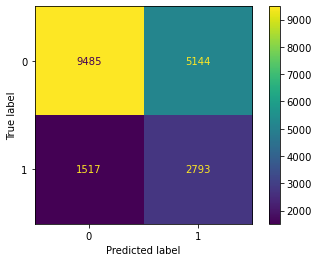

In [26]:
if study.best_params['penalty'] == 'l1':
    solver = 'saga'
else:
    solver = 'lbfgs'
    
model_lr = LogisticRegression(penalty=study.best_params['penalty'], C=study.best_params['logistic-regularization'],
                             solver=solver, max_iter=200, class_weight=class_weights)

model_lr.fit(X_train, y_train)
eval_model(model_lr, 'lr')

In [27]:
# report 10 most predictive features 
feature_names = ["GC content", "Gene length"] + [codon for codon in CodonDict.keys()] + ["CAI"] + \
[amino_acid for amino_acid in AminoAcidDict.keys()] + ["Strand", "Operon position_1", "Operon position_2"]

top_feat = np.argpartition(model_lr.coef_[0], -10)[-10:]
top_featnames = [feature_names[i] for i in top_feat]
print("The top 10 features are {}".format(", ".join(top_featnames)))

The top 10 features are P, AAA, ATT, GAG, GAT, GAC, ATC, GAA, S, F


### Random Forest

In [28]:
def create_model_rf(trial):
    estimators = trial.suggest_int('n_estimators', 100, 500)
    depth = trial.suggest_int('max_depth', 2, 12)
    split = trial.suggest_int('min_samples_split', 8, 24)
    model = RandomForestClassifier(n_estimators=estimators, max_depth=depth, min_samples_split=split,
                                  class_weight=class_weights)
    return model

def objective_rf(trial):
    model = create_model_rf(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, y_pred)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective_rf, n_trials=15)

[I 2022-08-24 20:41:31,459] A new study created in memory with name: no-name-3caa05ab-cc57-4a6c-a23f-2ea508b4fc75
[I 2022-08-24 20:41:56,622] Trial 0 finished with value: 0.7390056619269182 and parameters: {'n_estimators': 159, 'max_depth': 6, 'min_samples_split': 8}. Best is trial 0 with value: 0.7390056619269182.
[I 2022-08-24 20:43:25,210] Trial 1 finished with value: 0.7775829145494599 and parameters: {'n_estimators': 304, 'max_depth': 12, 'min_samples_split': 9}. Best is trial 1 with value: 0.7775829145494599.
[I 2022-08-24 20:44:15,589] Trial 2 finished with value: 0.7156328643264449 and parameters: {'n_estimators': 467, 'max_depth': 4, 'min_samples_split': 23}. Best is trial 1 with value: 0.7775829145494599.
[I 2022-08-24 20:44:57,396] Trial 3 finished with value: 0.7609684891333541 and parameters: {'n_estimators': 182, 'max_depth': 9, 'min_samples_split': 9}. Best is trial 1 with value: 0.7775829145494599.
[I 2022-08-24 20:45:22,012] Trial 4 finished with value: 0.7136720708804

The training AUC score is 0.955.
 The testing AUC score is 0.753


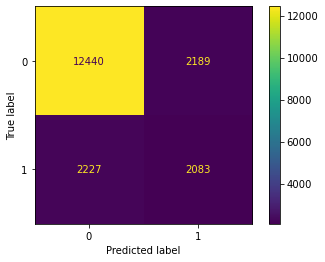

In [32]:
model_rf = RandomForestClassifier(n_estimators=study.best_params['n_estimators'], 
                                  max_depth=study.best_params['max_depth'],
                                  min_samples_split=study.best_params['min_samples_split'], 
                                  class_weight=class_weights)

model_rf.fit(X_train, y_train)
eval_model(model_rf, 'rf')

### XGBoost

In [33]:
def create_model_xgb(trial):
    l = trial.suggest_loguniform('lambda', 1e-2, 10)
    alpha = trial.suggest_loguniform('alpha', 1e-2, 10)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 0.8)
    depth = trial.suggest_int('max_depth', 1, 10)
    subsample = trial.suggest_float('subsample', 0.4, 0.7)
    model = XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='auc',
                         booster='gbtree', reg_lambda=l, alpha=alpha, max_depth=depth,
                         colsample_bytree=colsample_bytree, subsample=subsample, scale_pos_weight=neg/pos)
    return model

def objective_xgb(trial):
    model = create_model_xgb(trial)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, y_pred)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective_xgb, n_trials=15)

[I 2022-08-24 20:58:40,127] A new study created in memory with name: no-name-a74f9f3d-727a-4e5a-b6ce-dc2f86f44c7b
[I 2022-08-24 20:58:42,018] Trial 0 finished with value: 0.7677396305386981 and parameters: {'lambda': 0.8658321739222782, 'alpha': 6.607549074155665, 'colsample_bytree': 0.7331012341131735, 'max_depth': 3, 'subsample': 0.4200010656062225}. Best is trial 0 with value: 0.7677396305386981.
[I 2022-08-24 20:58:49,046] Trial 1 finished with value: 0.7568027733661219 and parameters: {'lambda': 0.06774491644018785, 'alpha': 0.05023735617664203, 'colsample_bytree': 0.6402762154783278, 'max_depth': 10, 'subsample': 0.5127130285542091}. Best is trial 0 with value: 0.7677396305386981.
[I 2022-08-24 20:58:50,012] Trial 2 finished with value: 0.730317856571763 and parameters: {'lambda': 4.502371681923247, 'alpha': 8.291400217266343, 'colsample_bytree': 0.7275481442727387, 'max_depth': 1, 'subsample': 0.6565469649151738}. Best is trial 0 with value: 0.7677396305386981.
[I 2022-08-24 20:

The training AUC score is 0.999.
 The testing AUC score is 0.767


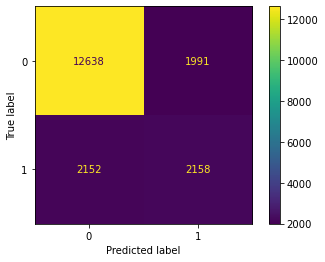

In [34]:
model_xgb = XGBClassifier(use_label_encoder=False, objective='binary:logistic', eval_metric='auc',
                          booster='gbtree', reg_lambda=study.best_params['lambda'], alpha=study.best_params['alpha'],
                          scale_pos_weight=neg/pos, max_depth=study.best_params['max_depth'],
                          colsample_bytree=study.best_params['colsample_bytree'], 
                          subsample=study.best_params['subsample'])

model_xgb.fit(X_train, y_train)
eval_model(model_xgb, 'xgb')

# MLP

In [35]:
num_classes = 2
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

batch_size = 128
epochs = 100

In [37]:
def create_model_mlp(trial):
    n_layers = trial.suggest_int('n_layers', 1, 4)
    model = Sequential()
    for i in range(n_layers):
        num_hidden = trial.suggest_int('n_units_l{}'.format(i), 4, 256, log=True)
        model.add(Dense(num_hidden, activation='relu'))
        dropout = trial.suggest_float('dropout_l{}'.format(i), 0.3, 0.5)
        model.add(Dropout(rate=dropout))
    model.add(Dense(num_classes, activation='softmax'))
    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['AUC']
    )
    
    return model

early_stopping = EarlyStopping(
    monitor='val_loss',
    verbose=0,
    patience=15,
    mode='min',
    restore_best_weights=True
)

def objective_mlp(trial):
    model = create_model_mlp(trial)
    model.fit(X_train, y_train, batch_size=batch_size, callbacks=[early_stopping], epochs=epochs,
             validation_data=(X_val, y_val), verbose=0, class_weight=class_weights)
    score = model.evaluate(X_val, y_val, verbose=0)
    return score[1]

study = optuna.create_study(direction='maximize')
study.optimize(objective_mlp, n_trials=15)

[I 2022-08-24 21:13:45,704] A new study created in memory with name: no-name-3290baa1-fbcf-40ab-8937-1fc1c7b9bc3f
[I 2022-08-24 21:15:54,278] Trial 0 finished with value: 0.769393265247345 and parameters: {'n_layers': 3, 'n_units_l0': 4, 'dropout_l0': 0.3760271325183997, 'n_units_l1': 7, 'dropout_l1': 0.4070428166825616, 'n_units_l2': 99, 'dropout_l2': 0.36885229962114685, 'learning_rate': 0.059133390433588104}. Best is trial 0 with value: 0.769393265247345.
[I 2022-08-24 21:17:05,350] Trial 1 finished with value: 0.8102617859840393 and parameters: {'n_layers': 1, 'n_units_l0': 12, 'dropout_l0': 0.3225343308894136, 'learning_rate': 0.0009542549334182096}. Best is trial 1 with value: 0.8102617859840393.
[I 2022-08-24 21:18:03,507] Trial 2 finished with value: 0.8209121227264404 and parameters: {'n_layers': 4, 'n_units_l0': 22, 'dropout_l0': 0.3207751205156576, 'n_units_l1': 9, 'dropout_l1': 0.3694413887901066, 'n_units_l2': 94, 'dropout_l2': 0.3717278304490685, 'n_units_l3': 19, 'dropou

In [46]:
input_shape = X_train.shape[1]
model_mlp = Sequential()
j = 0

for key, value in study.best_params.items():
    if not key.__contains__('n_units') and not key.__contains__('dropout'):
        continue
    else:
        if key.__contains__('n_units'):
            if j == 0:
                model_mlp.add(Dense(value, input_shape=(input_shape,), activation="relu"))
                j += 1
            else:
                model_mlp.add(Dense(value, activation="relu"))
        else:
            model_mlp.add(Dropout(rate=value))

model_mlp.add(Dense(num_classes, activation="softmax"))

model_mlp.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=study.best_params['learning_rate']),
              metrics=['AUC'])

In [47]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20, restore_best_weights=True)

history = model_mlp.fit(X_train, y_train, batch_size=batch_size, epochs=500, validation_data=(X_val, y_val),
        verbose=0, class_weight=class_weights, callbacks = [es])

The training AUC score is 0.836.
 The testing AUC score is 0.799


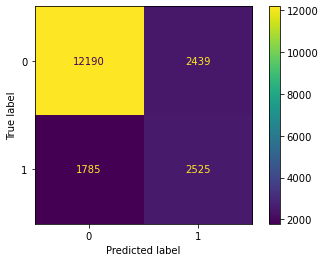

In [48]:
eval_model(model_mlp, 'mlp')

In [49]:
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_mlp.predict(np.stack(X_test)), axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85     14629
           1       0.51      0.59      0.54      4310

    accuracy                           0.78     18939
   macro avg       0.69      0.71      0.70     18939
weighted avg       0.79      0.78      0.78     18939



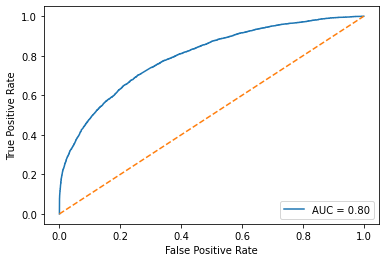

In [50]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, model_mlp.predict(np.stack(X_test))[:,1])
roc_auc = sklearn.metrics.auc(fpr, tpr)

fig = sklearn.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.plot([0, 1], [0, 1], '--')
plt.show()